### About the dataset
This dataset is about past loans.   
The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted.  
It includes the following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


This is a problem of binary classification.  
I will build a model with different classification algorithms from historical training data and then use these models to predict the loan status of a new customer from test data.

### Downloading the data and loading modules

The data is stored on the IBM Object storage and will be downloaded.  
The necessary Python libraries Pandas, Numpy, Matplotlib, Itertools and Scikit-learn will be imported and then read into a Pandas dataframe.

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2018-11-14 10:35:27--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2018-11-14 10:35:27 (11.2 MB/s) - ‘loan_train.csv’ saved [23101/23101]



In [2]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
df.shape

(346, 10)

### Data pre-processing and visualization
Let's convert the due dates to a date time object:

In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


Let's see how many people have paid off their loan:

In [5]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

Apparently, 260 people have paid off the loan on time while 86 have gone into collection.

Let's plot some columns to underestand the data better. 
For the visualization, I will use the Python library **Seaborn** which extends the matplotlib library and provides additional statistical plotting functions.


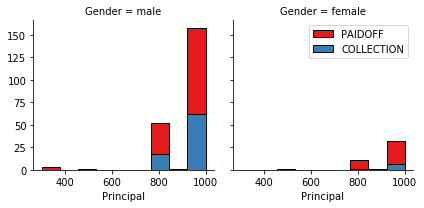

In [6]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

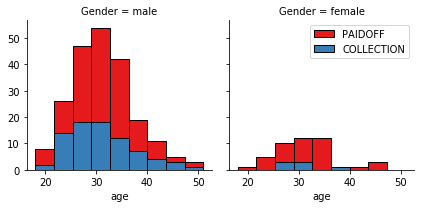

In [7]:
bins=np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

Clearly, women are more likely to pay off their loans.   
Also, mostly middle aged customers default on their loans.  
Furthermore, the probability to default is higher for men with higher principal sums.

### Pre-processing: Feature selection/extraction
Let's take a look at the day of the week people get the loan:

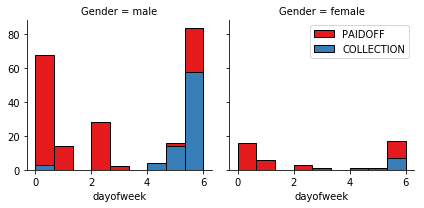

In [8]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins=np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

Apparently, people who get the loan at the end of the week dont pay it off.  
Let's use Feature binarization to set a threshold value of higher then day 4 for weekend.

In [9]:
df['weekend']= df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


#### Conversion of Categorical features to numerical values
First, let's consider gender:

In [10]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

Apparently, 86.5 % of women pay off their loans while only 73.1 % of men pay their loans.  
Lets convert male to 0 and female to 1:


In [11]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


#### One-hot encoding
Secondly, let's look at education:

In [12]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

Let's take a quick look at our features before we apply one-hot encoding:

In [13]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


Also, let's see how many customers are of each education class:

In [15]:
df.groupby(['education'])['loan_status'].count()

education
Bechalor                 44
High School or Below    151
Master or Above           2
college                 149
Name: loan_status, dtype: int64

Now, I will use one-hot encoding via Pandas get_dummies() function and convert the categorical variables in the education column to numerical values and then append them to the DataFrame.  
The column for **Master or Above** will be dropped, since we only have 2 customers and these two singular rows don't allow statistical evaluation.

In [14]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


#### Feature selection 
Let's define our feature sets X and our target set y:

In [16]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [17]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

#### Data normalization
Now, the training data will be normalized.  
Data Standardization gives data zero mean and unit variance in order to give each feature equal contribution to the target variable.  
Fitting finds the internal parameters of a model that will be used to transform data.  
Transforming applies the parameters to data.

In [18]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

### Classification
Now, the training set will be used to build an accurate model.   
Later, I will use the test set to report the accuracy of each model.  
I will use the following algorithms:
- K Nearest Neighbor (KNN)
- Decision Tree
- Support Vector Machine (SVM)
- Logistic Regression

#### K-nearest-neighbor
We have to find the best k to build the model with the best accuracy.  
I will split the train_loan.csv into train and test to find the best k.
Since train_test_split will return 4 different parameters, I will name them: X_train, X_test, y_train, y_test and use the parameters X, y, test_size=0.2, and random_state=4.

In [19]:
# We split the X into train and test to find the best k
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


Let's try k=3 first:

In [20]:
# Modeling
from sklearn.neighbors import KNeighborsClassifier
k = 3
#Train Model and Predict  
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
kNN_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [21]:
# just for sanity check
yhat = kNN_model.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

Now, let's find the best k:

In [24]:
# Best k
Ks=70
mean_acc=np.zeros((Ks-1))
std_acc=np.zeros((Ks-1))
ConfustionMx=[];
for n in range(1,Ks):
    
    #Train Model and Predict  
    kNN_model = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    yhat = kNN_model.predict(X_test)
    
    
    mean_acc[n-1]=np.mean(yhat==y_test);
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([ 0.67142857,  0.65714286,  0.71428571,  0.68571429,  0.75714286,
        0.71428571,  0.78571429,  0.75714286,  0.75714286,  0.67142857,
        0.7       ,  0.72857143,  0.7       ,  0.7       ,  0.68571429,
        0.72857143,  0.72857143,  0.72857143,  0.7       ,  0.68571429,
        0.71428571,  0.68571429,  0.7       ,  0.7       ,  0.72857143,
        0.71428571,  0.77142857,  0.68571429,  0.78571429,  0.75714286,
        0.78571429,  0.74285714,  0.78571429,  0.78571429,  0.78571429,
        0.75714286,  0.78571429,  0.78571429,  0.78571429,  0.78571429,
        0.77142857,  0.77142857,  0.77142857,  0.78571429,  0.77142857,
        0.78571429,  0.78571429,  0.78571429,  0.78571429,  0.78571429,
        0.78571429,  0.78571429,  0.78571429,  0.78571429,  0.78571429,
        0.78571429,  0.78571429,  0.78571429,  0.78571429,  0.78571429,
        0.78571429,  0.78571429,  0.78571429,  0.78571429,  0.78571429,
        0.78571429,  0.78571429,  0.78571429,  0.78571429])

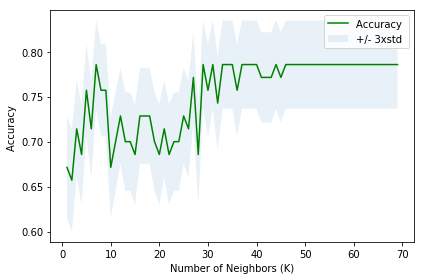

In [25]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [26]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.785714285714 with k= 7


Since we know, that the best model accuracy is achieved with k=7, we will rebuild our model with this k:

In [27]:
# Building the model again, using k=7
from sklearn.neighbors import KNeighborsClassifier
k = 7
#Train Model and Predict  
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
kNN_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

#### Decision tree
Let's import the required library from sk-learn and set our decision tree classifier criterion to Entropy in order to maximize the information gain after each branching:

In [28]:
from sklearn.tree import DecisionTreeClassifier
DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DT_model.fit(X_train,y_train)
DT_model

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Let's use our model to make a prediction on the test set:

In [29]:
yhat = DT_model.predict(X_test)
yhat

array(['COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF'], dtype=object)

#### Support vector machine (SVM)
Let's import the required library from sk-learn and build our model:

In [30]:
from sklearn import svm
SVM_model = svm.SVC()
SVM_model.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Let's give a prediction on our test set:

In [31]:
yhat = SVM_model.predict(X_test)
yhat

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

#### Logistic regression
Let's import the required library from sk-learn and build the model with a C value of 0.01 in order to reduce the strength of outliers, i.e. to underfit outliers.  
Remember that we use the parameter C as the regularization parameter.   
**Parameter C = 1/λ**  
Lambda (λ) controls the trade-off between allowing the model to increase it's complexity as much as it wants with trying to keep it simple.  
For example, if λ is very low or 0, the model will have enough power to increase it's complexity (overfit) by assigning big values to the weights for each parameter.  
If, in the other hand, we increase the value of λ, the model will tend to underfit, as the model will become too simple.  
Parameter C will work the other way around.  
For small values of C, we increase the regularization strength which will create simple models which underfit the data.  
For big values of C, we lower the power of regularization which imples the model is allowed to increase it's complexity, and therefore, overfit the data.

In [32]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(C=0.01).fit(X_train,y_train)
LR_model

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's give a prediction on our test data:

In [33]:
yhat = LR_model.predict(X_test)
yhat

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF'], dtype=object)

### Model evaluation using the actual test set
Now, we will finally use the real-world test set and see how our models tackle the classification.  
Let's load the required libraries for metric accuracy and the test data first and read the test data into a Pandas dataframe:

In [34]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
    
test_df = pd.read_csv('loan_test.csv')
test_df.head()

--2018-11-14 12:13:18--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2018-11-14 12:13:18 (562 MB/s) - ‘loan_test.csv’ saved [3642/3642]



,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Data pre-processing of test data
Now, the test data will receive the same pre-processing as our training data in order to allow comparison:

In [35]:
## Preprocessing

#Date pre-processing
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

#introduce weekend
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

#conversion of categorical gender to binary 
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

#drop the Master or Above column after one-hot encoding
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)

#Data normalization of test data
test_X = preprocessing.StandardScaler().fit(test_Feature).transform(test_Feature)
test_X[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

Let's take a quick look at our loan_status before we use our models to classify the data:

In [36]:
test_y = test_df['loan_status'].values
test_y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

Now, all classification models will classify the test data and accuracy scores such as Jaccard index, F1 score and Logloss will be calculated.

In [37]:
knn_yhat = kNN_model.predict(test_X)
print("KNN Jaccard index: %.2f" % jaccard_similarity_score(test_y, knn_yhat))
print("KNN F1-score: %.2f" % f1_score(test_y, knn_yhat, average='weighted') )

KNN Jaccard index: 0.67
KNN F1-score: 0.63


In [38]:
DT_yhat = DT_model.predict(test_X)
print("DT Jaccard index: %.2f" % jaccard_similarity_score(test_y, DT_yhat))
print("DT F1-score: %.2f" % f1_score(test_y, DT_yhat, average='weighted') )

DT Jaccard index: 0.72
DT F1-score: 0.74


In [39]:
SVM_yhat = SVM_model.predict(test_X)
print("SVM Jaccard index: %.2f" % jaccard_similarity_score(test_y, SVM_yhat))
print("SVM F1-score: %.2f" % f1_score(test_y, SVM_yhat, average='weighted') )

SVM Jaccard index: 0.80
SVM F1-score: 0.76


In [40]:
LR_yhat = LR_model.predict(test_X)
LR_yhat_prob = LR_model.predict_proba(test_X)
print("LR Jaccard index: %.2f" % jaccard_similarity_score(test_y, LR_yhat))
print("LR F1-score: %.2f" % f1_score(test_y, LR_yhat, average='weighted') )
print("LR LogLoss: %.2f" % log_loss(test_y, LR_yhat_prob))

LR Jaccard index: 0.74
LR F1-score: 0.66
LR LogLoss: 0.57


### Report
Here is our report of the accuracy of each built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.67    | 0.63     | NA      |
| Decision Tree      | 0.72    | 0.74     | NA      |
| SVM                | 0.80    | 0.76     | NA      |
| LogisticRegression | 0.74    | 0.66     | 0.57    |